In [1]:
""" A clean, no_frills character-level generative language model.
Created by Danijar Hafner, edited by Chip Huyen
for the class CS 20SI: "TensorFlow for Deep Learning Research"
Based on Andrej Karpathy's blog: 
http://karpathy.github.io/2015/05/21/rnn-effectiveness/
"""
import os
import time

import tensorflow as tf
import numpy as np
%autosave 0

Autosave disabled


In [2]:
DATA_PATH = 'arvix_abstracts.txt'
HIDDEN_SIZE = 200
BATCH_SIZE = 64
NUM_STEPS = 50
SKIP_STEP = 40
TEMPERATURE = 0.7
LR = 0.003
LEN_GENERATED = 10
ITERATIONS = 101

def vocab_encode(text, vocab):
    return [vocab.index(x) + 1 for x in text if x in vocab]

def vocab_decode(array, vocab):
    return ''.join([vocab[x - 1] for x in array])

def read_data(filename, vocab, window=NUM_STEPS, overlap=NUM_STEPS/2):
    for text in open(filename):
        text = vocab_encode(text, vocab)
        for start in range(0, len(text) - window, int(overlap)):
            chunk = text[start: start + window]
            chunk += [0] * (window - len(chunk))
            yield chunk

def read_batch(stream, batch_size=BATCH_SIZE):
    batch = []
    for element in stream:
        batch.append(element)
        if len(batch) == batch_size:
            yield batch
            batch = []
    yield batch

In [3]:
def create_rnn(seq, hidden_size=HIDDEN_SIZE):
    cell = tf.contrib.rnn.GRUCell(hidden_size)
    # cell = tf.contrib.rnn.GRUCell(hidden_size, reuse=True) # added 'reuse=True' JC
    
    in_state = tf.placeholder_with_default(
            cell.zero_state(tf.shape(seq)[0], tf.float32), [None, hidden_size])
    # this line to calculate the real length of seq
    # all seq are padded to be of the same length which is NUM_STEPS
    length = tf.reduce_sum(tf.reduce_max(tf.sign(seq), 2), 1)
    output, out_state = tf.nn.dynamic_rnn(cell, seq, length, in_state)
    return output, in_state, out_state

def create_model(seq, temp, vocab, hidden=HIDDEN_SIZE):
    seq = tf.one_hot(seq, len(vocab))
    output, in_state, out_state = create_rnn(seq, hidden)
    # fully_connected is syntactic sugar for tf.matmul(w, output) + b
    # it will create w and b for us
    logits = tf.contrib.layers.fully_connected(output, len(vocab), None)
    loss = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(logits=logits[:, :-1], labels=seq[:, 1:]))
    # sample the next character from Maxwell-Boltzmann Distribution with temperature temp
    # it works equally well without tf.exp
    dist = tf.exp(logits[:,-1]) # added
    print("dist",dist)
    sample = tf.multinomial(tf.exp(logits[:, -1] / temp), 1)[:, 0] 
    return loss, sample, in_state, out_state, logits, dist

In [4]:
def training(vocab, seq, loss, optimizer, global_step, temp, sample, in_state, out_state):
    saver = tf.train.Saver()
    start = time.time()
    # sess = tf.InteractiveSession():
    writer = tf.summary.FileWriter('graphs/gist', sess.graph)
    sess.run(tf.global_variables_initializer())

    ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/checkpoint'))
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)

    iteration = global_step.eval()

    for batch in read_batch(read_data(DATA_PATH, vocab)):
        batch_loss, _ = sess.run([loss, optimizer], {seq: batch})
        if (iteration + 1) % SKIP_STEP == 0:
            print('Iter {}. \n    Loss {}. Time {}'.format(iteration, batch_loss, time.time() - start))
            online_inference(sess, vocab, seq, sample, temp, in_state, out_state)
            start = time.time()
            saver.save(sess, 'checkpoints/char-rnn', iteration)
        iteration += 1
        if iteration > ITERATIONS:
            break

def online_inference(sess, vocab, seq, sample, temp, in_state, out_state, seed='science an'):
    """ Generate sequence one character at a time, based on the previous character
    """
    sentence = seed
    state = None
    for _ in range(LEN_GENERATED):
        batch = [vocab_encode(sentence[-1], vocab)]
        feed = {seq: batch, temp: TEMPERATURE}
        # for the first decoder step, the state is None
        if state is not None:
            feed.update({in_state: state})
        index, state = sess.run([sample, out_state], feed)
        sentence += vocab_decode(index, vocab)
    print(sentence)

In [5]:
vocab = (
        " $%'()+,-./0123456789:;=?ABCDEFGHIJKLMNOPQRSTUVWXYZ"
        "\\^_abcdefghijklmnopqrstuvwxyz{|}")
seq = tf.placeholder(tf.int32, [None, None])
temp = tf.placeholder(tf.float32)
loss, sample, in_state, out_state, my_logits, my_dist = create_model(seq, temp, vocab)
global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')
optimizer = tf.train.AdamOptimizer(LR).minimize(loss, global_step=global_step)

sess = tf.InteractiveSession()
training(vocab, seq, loss, optimizer, global_step, temp, sample, in_state, out_state)

dist Tensor("Exp:0", shape=(?, 83), dtype=float32)
INFO:tensorflow:Restoring parameters from checkpoints/char-rnn-79


In [6]:
sentence = " th"
batch = [vocab_encode(sentence[-1], vocab)]
feed = {seq: batch, temp: TEMPERATURE}
index, state, my_logits2, my_dist2 = sess.run([sample, out_state, my_logits, my_dist], feed)
sentence += vocab_decode(index, vocab)
print('"' + sentence + '"')
print(my_logits)

" the"
Tensor("fully_connected/BiasAdd:0", shape=(?, ?, 83), dtype=float32)


In [7]:
# print(sess.run(my_logits))

In [8]:
my_logits2

array([[[ -5.37657857e-01,   6.52831793e-01,  -3.22205007e-01,
          -5.24747908e-01,  -3.57738554e-01,  -4.02318031e-01,
          -2.83923477e-01,  -6.05260491e-01,   5.61404973e-03,
          -1.37775362e-01,   4.72431928e-02,  -4.33688134e-01,
          -3.35199624e-01,  -4.23463941e-01,  -3.92651379e-01,
          -4.42778081e-01,  -5.91963887e-01,  -4.39200878e-01,
          -5.26755631e-01,  -6.39856517e-01,  -6.13228500e-01,
          -3.55813801e-01,  -5.69908738e-01,  -4.30042446e-01,
          -6.50804758e-01,  -6.14313364e-01,  -3.26985300e-01,
          -5.05590200e-01,  -4.78919178e-01,  -2.25222528e-01,
          -4.08690035e-01,  -4.48552012e-01,  -3.31406832e-01,
          -4.96375740e-01,  -4.90113318e-01,  -6.13850653e-01,
          -6.25368476e-01,  -3.91443193e-01,  -3.95976871e-01,
          -1.02374360e-01,  -5.14436841e-01,  -5.75380921e-01,
          -5.72396338e-01,  -3.24668825e-01,  -3.95890862e-01,
          -3.20663005e-01,  -5.07841349e-01,  -4.892848

In [9]:
my_logits2[0][0].shape

(83,)

In [10]:
np.argmax(my_logits2[0][0])

59

In [11]:
vocab[54]

'a'

In [12]:
vocab[np.argmax(my_dist2[0])-1]

'e'

In [13]:
indices = np.argsort(my_dist2[0])[::-1]
myseq = ""
for x in indices[:20]:
    myseq +=vocab[x-1]
myseq

'e iaoyuhsgrmnpld.v,c'

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['indices', 'sample']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


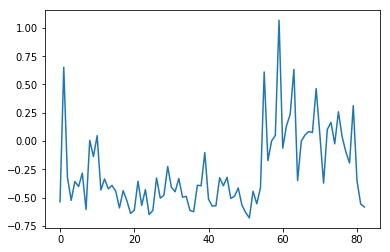

In [14]:
%pylab inline
plt.plot(range(83),my_logits2[0][0])

In [15]:
my_dist2.shape

(1, 83)

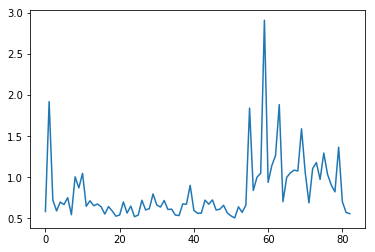

In [16]:
plt.plot(range(83),my_dist2[0])